<a href="https://colab.research.google.com/github/Jarvis1000x/Project/blob/master/Analysis_of_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
houses = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data.csv') 

In [4]:
houses.shape

(4600, 18)

In [5]:
houses.dtypes

date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object

In [6]:
"The average price of a house is ${:,.0f}".format(houses.price.mean())

'The average price of a house is $551,963'

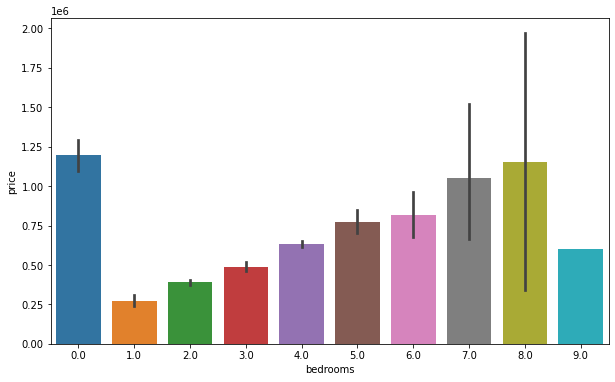

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(x=houses.bedrooms, y=houses['price'])

In [8]:
bybedroom = houses.groupby(['bedrooms']).price.agg([len, min, max])

In [9]:
bybedroom

,len,min,max
bedrooms,,,
0.0,2.0,1095000.0,1295648.0
1.0,38.0,0.0,540000.0
2.0,566.0,0.0,1695000.0
3.0,2032.0,0.0,26590000.0
4.0,1531.0,0.0,4489000.0
5.0,353.0,0.0,7062500.0
6.0,61.0,0.0,3100000.0
7.0,14.0,280000.0,3200000.0
8.0,2.0,340000.0,1970000.0


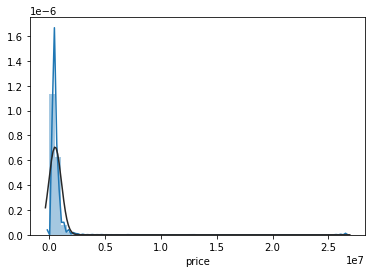

In [10]:
sns.distplot(houses['price'], fit=norm)

In [12]:
#The problems are :
#Houses with no Bedrooms
#27 Million Dollars House
#49 Houses with no price
houses_o = houses[(houses.price<2.5*10**7) & (houses.bedrooms>0) & (houses.price>0)].copy()

In [13]:
#We will group the houses with 7, 8 and 9 bedrooms with the houses featuring 6 bedrooms
houses_o['bedrooms_recoded'] = houses_o['bedrooms'].replace([7,8,9],6)

In [14]:
houses_o['renovated_0_1'] = houses_o['yr_renovated']/houses_o['yr_renovated']
houses_o['renovated_0_1'] = houses_o['renovated_0_1'].fillna(0)

In [15]:
#For features we'll pick the following:
#bedrooms_recoded
#floors
#view
#condition
#renovated_0_1
X = houses_o.loc[:,['bedrooms_recoded', 'floors','view','condition','renovated_0_1']]
y = houses_o.loc[:,['price']] 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42
                                                   )

In [17]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                              1433.
Date:                Sat, 22 Aug 2020   Prob (F-statistic):                        0.00
Time:                        07:12:10   Log-Likelihood:                         -45489.
No. Observations:                3183   AIC:                                  9.099e+04
Df Residuals:                    3178   BIC:                                  9.102e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [18]:
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

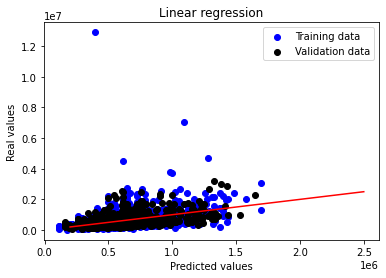

In [19]:
plt.scatter(train_pre, y_train, c = "blue",  label = "Training data")
plt.scatter(test_pre, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper right")
plt.plot([0.2*10**6, 0.25*10**7], [0.2*10**6, 0.25*10**7], c = "red")
plt.show()

In [20]:
res = pd.DataFrame(data=train_pre, columns=['predicted values'])
res = y_train.reset_index().join(res)
resfin = res.join(X_train, on='index',lsuffix='_y')
resfin['predprice']=res['predicted values']
resfin['actprice']=res['price']
resfin['error']=resfin['predprice']-resfin['actprice']

In [21]:
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
res_test = y_test.reset_index().join(res_test)
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['price']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [22]:
"The mean error is ${:,.0f}".format(resfin_test['error'].mean())

'The mean error is $13,968'

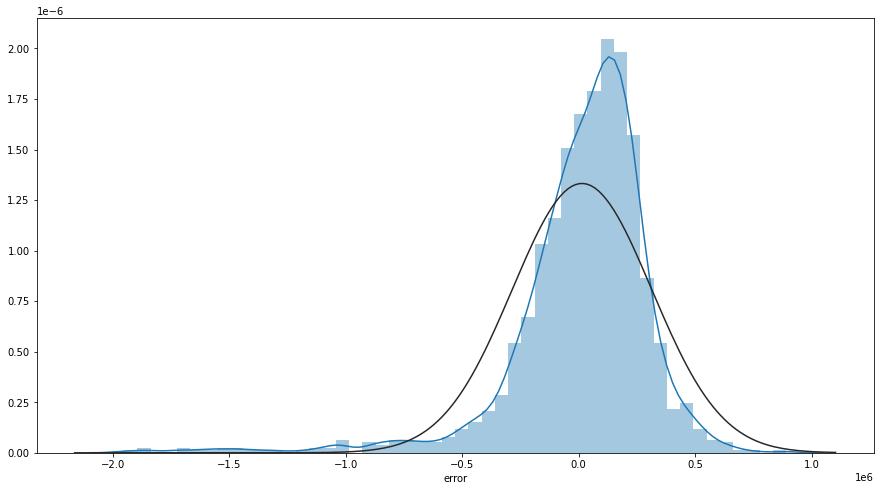

In [23]:
plt.figure(figsize=(15,8))
sns.distplot(resfin_test['error'], fit=norm)

In [25]:
import numpy as np

In [27]:
from scipy import stats

In [28]:
x_array = np.array(resfin_test['error'])
normalized_X = stats.zscore(x_array)

In [29]:
error_df = pd.DataFrame(data=normalized_X.T, columns=['normalized error'])
resfin2 = resfin_test.join(error_df)
resfin2['abs_norm_error'] = abs(resfin2['normalized error'])
resfin2['massive underestimation'] = resfin2['normalized error']<-2

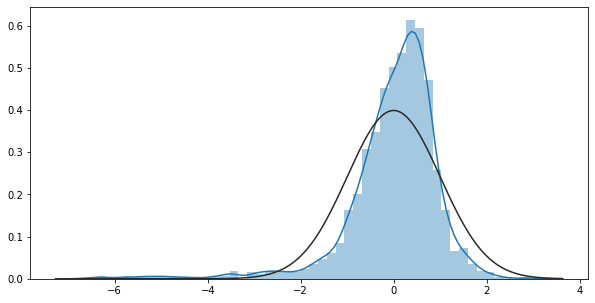

In [30]:
plt.figure(figsize=(10,5))
sns.distplot(error_df, fit=norm)

In [31]:
resfin2['massive underestimation'].value_counts()

False    1315
True       50
Name: massive underestimation, dtype: int64

No handles with labels found to put in legend.


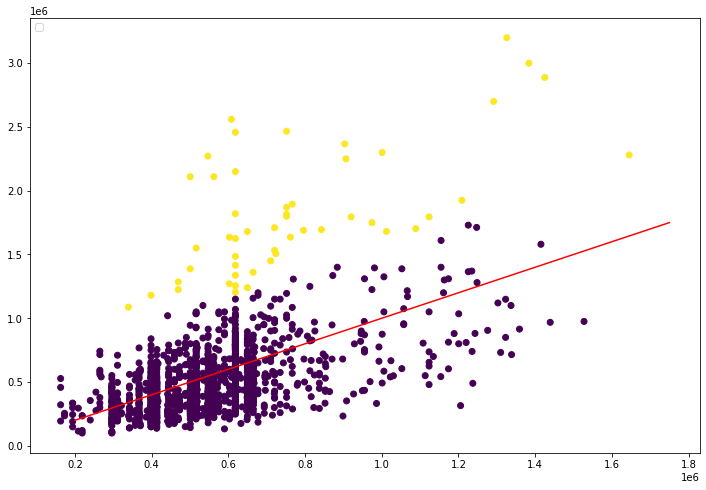

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(resfin2['predprice'], resfin2['actprice'], c = resfin2['massive underestimation'])
plt.plot([0.2*10**6, 1.75*10**6], [0.2*10**6, 1.75*10**6], c = "red")
plt.legend(loc = "upper left")

In [33]:
pd.crosstab(resfin2['bedrooms_recoded'],resfin2['massive underestimation']).apply(lambda r: r/r.sum(), axis=1)

massive underestimation,False,True
bedrooms_recoded,,
1.0,1.000000,0.000000
2.0,0.987730,0.012270
3.0,0.988543,0.011457
4.0,0.947368,0.052632
5.0,0.870690,0.129310
6.0,0.842105,0.157895


[Text(0, 0, 'WA 98039'),
 Text(0, 0, 'WA 98004'),
 Text(0, 0, 'WA 98040'),
 Text(0, 0, 'WA 98109'),
 Text(0, 0, 'WA 98112'),
 Text(0, 0, 'WA 98119'),
 Text(0, 0, 'WA 98105'),
 Text(0, 0, 'WA 98033'),
 Text(0, 0, 'WA 98006'),
 Text(0, 0, 'WA 98005'),
 Text(0, 0, 'WA 98075'),
 Text(0, 0, 'WA 98053'),
 Text(0, 0, 'WA 98077'),
 Text(0, 0, 'WA 98102'),
 Text(0, 0, 'WA 98199'),
 Text(0, 0, 'WA 98074'),
 Text(0, 0, 'WA 98052'),
 Text(0, 0, 'WA 98122'),
 Text(0, 0, 'WA 98007'),
 Text(0, 0, 'WA 98116'),
 Text(0, 0, 'WA 98177'),
 Text(0, 0, 'WA 98024'),
 Text(0, 0, 'WA 98029'),
 Text(0, 0, 'WA 98050'),
 Text(0, 0, 'WA 98027'),
 Text(0, 0, 'WA 98115'),
 Text(0, 0, 'WA 98065'),
 Text(0, 0, 'WA 98117'),
 Text(0, 0, 'WA 98103'),
 Text(0, 0, 'WA 98008'),
 Text(0, 0, 'WA 98072'),
 Text(0, 0, 'WA 98068'),
 Text(0, 0, 'WA 98107'),
 Text(0, 0, 'WA 98051'),
 Text(0, 0, 'WA 98011'),
 Text(0, 0, 'WA 98059'),
 Text(0, 0, 'WA 98034'),
 Text(0, 0, 'WA 98070'),
 Text(0, 0, 'WA 98136'),
 Text(0, 0, 'WA 98144'),


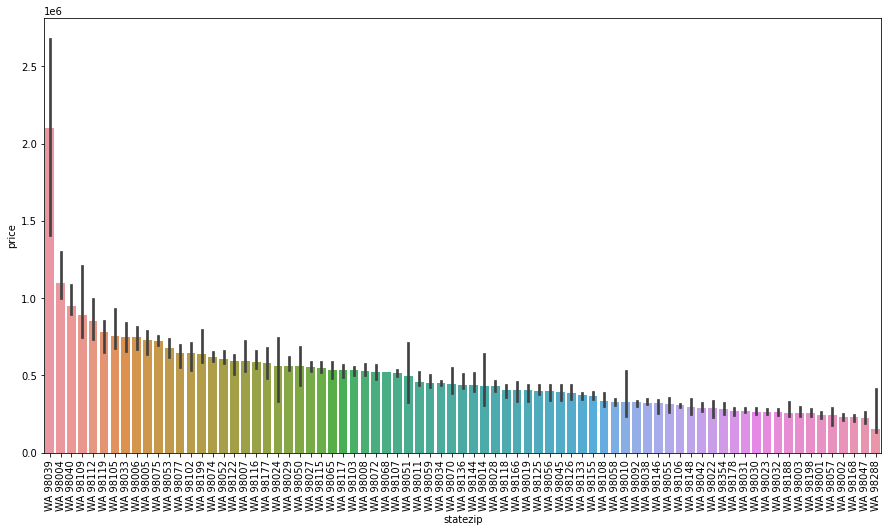

In [34]:
#visualising the price of a house and the zip code
result = houses_o.groupby(["statezip"])['price'].aggregate(np.median).reset_index().sort_values('price', ascending=False)
plt.figure(figsize=(15,8))
chart = sns.barplot(
    x='statezip',
    y='price',
    data=houses_o,
    order = result['statezip'],
    estimator=np.median
    
    
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [35]:
houses_o['posh_zip'] = houses_o['statezip'].isin(['WA 98039','WA 98004','WA 98040','WA 98109']).astype(int)

In [36]:
X = houses_o.loc[:,['bedrooms_recoded', 'floors', 'condition','view','renovated_0_1', 'posh_zip']]
y = houses_o.loc[:,['price']]

In [37]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                              1433.
Date:                Sat, 22 Aug 2020   Prob (F-statistic):                        0.00
Time:                        07:37:03   Log-Likelihood:                         -45489.
No. Observations:                3183   AIC:                                  9.099e+04
Df Residuals:                    3178   BIC:                                  9.102e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [38]:
lr = LinearRegression()
lr.fit(X_train,y_train)
test_pre = lr.predict(X_test)
train_pre = lr.predict(X_train)

In [39]:
res_test = pd.DataFrame(data=test_pre, columns=['predicted values'])
res_test = y_test.reset_index().join(res_test)
resfin_test = res_test.join(X_test, on='index',lsuffix='_y')
resfin_test['predprice']=resfin_test['predicted values']
resfin_test['actprice']=resfin_test['price']
resfin_test['error']=resfin_test['predprice']-resfin_test['actprice']
resdf = pd.concat([resfin,resfin_test])

In [40]:
x_array = np.array(resfin_test['error'])
normalized_X = stats.zscore(x_array)

In [41]:
error_df = pd.DataFrame(data=normalized_X.T, columns=['normalized error'])
resfin2 = resfin_test.join(error_df)
resfin2['abs_norm_error'] = abs(resfin2['normalized error'])
resfin2['massive underestimation'] = resfin2['normalized error']<-2

No handles with labels found to put in legend.


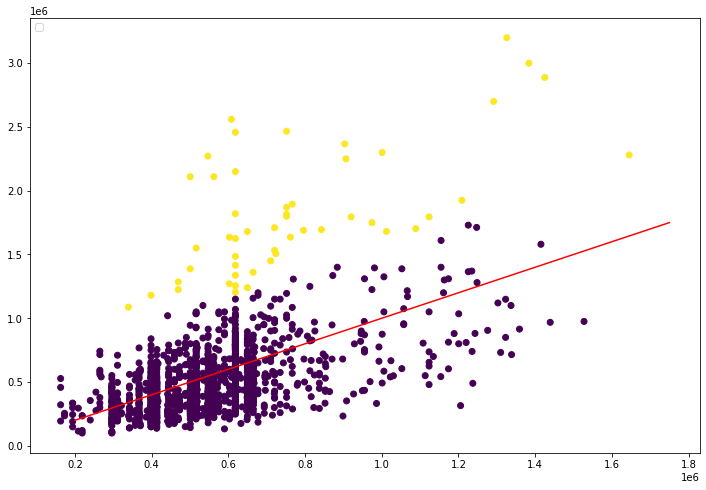

In [42]:
plt.figure(figsize=(12,8))
plt.scatter(resfin2['predprice'], resfin2['actprice'], c = resfin2['massive underestimation'])
plt.plot([0.2*10**6, 1.75*10**6], [0.2*10**6, 1.75*10**6], c = "red")
plt.legend(loc = "upper left")

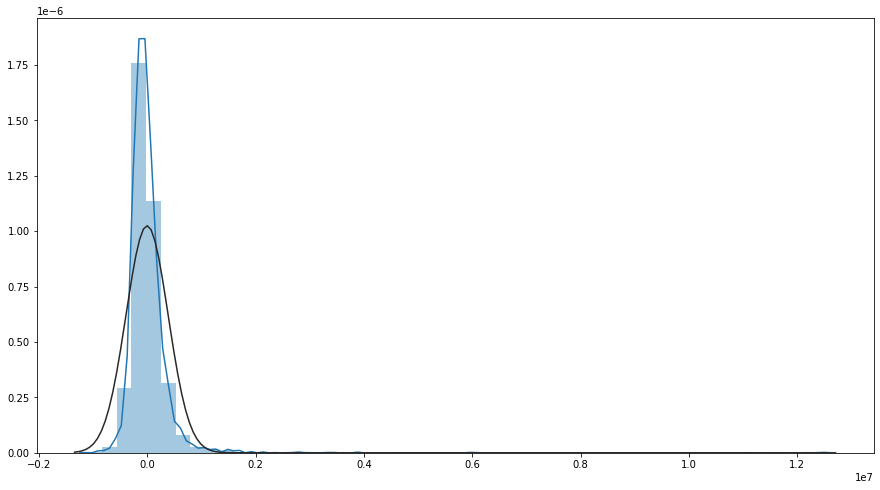

In [43]:
plt.figure(figsize=(15,8))
sns.distplot(res.resid, fit=norm)

In [44]:
X = houses_o.loc[:,['sqft_living','condition', 'yr_built']]
y = houses_o.loc[:,['price']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42
                                                   )

In [46]:
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.762
Model:                            OLS   Adj. R-squared (uncentered):              0.762
Method:                 Least Squares   F-statistic:                              3389.
Date:                Sat, 22 Aug 2020   Prob (F-statistic):                        0.00
Time:                        07:44:48   Log-Likelihood:                         -45084.
No. Observations:                3183   AIC:                                  9.017e+04
Df Residuals:                    3180   BIC:                                  9.019e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

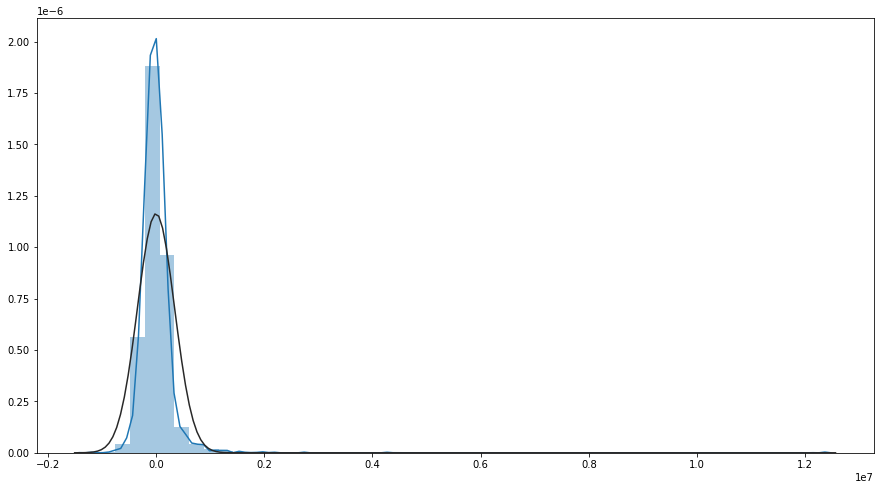

In [47]:
plt.figure(figsize=(15,8))
sns.distplot(res.resid, fit=norm)

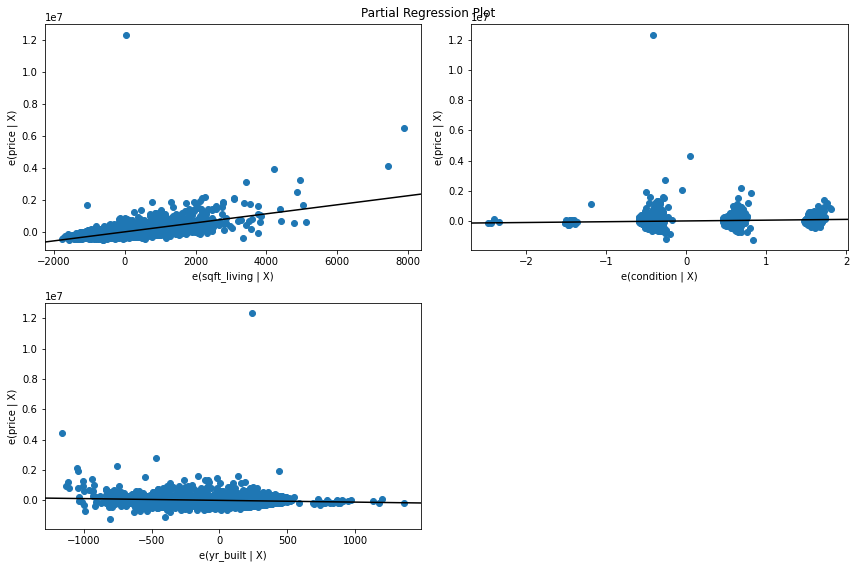

In [48]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(res, fig=fig)